# VYRESIT 
- CALL 3.10.
    - evaluace na spekterech, ktery NEIMS nevidel (NIST20 minus NIST17)
    - evaluace pomoci Discounted cumulative gain
    - spojit test modelu s testem similarities
    - NEBO spocitat grafy na pripadech, kdy se transformer TREFIL na PRESNO 
    - DERIVATIZACE??? napsat si s ALesem

- generate ma moznost num_return_sequences kterou by bylo fajn hodit do generate_smiles (done)
    - taky by bylo dobry vsechny obecny fce nahazet do nejakyho utils.py, at se s tim nemusis furt prcat a je to prehlednejsi
           - a taky at nejsou duplicity
- co ten TOKENIZER_TYPE??? to sprav, nedava to smysl takto... -> ta fce neni samostatna jednotka a spoliha na global variable

- OPTION1 (unique value znovu preevaluovat)

- PROBLEM RMSE:
    - kdyz je nahodou jinej pocet indexu, kazi to vysledek. (staci jenom zmenit ordering?)
- aby skripty jely z notebooku
  - nebo aby to cely jelo ve skriptu

# Extended inference
- OPTION 1
    - for each generated SMILES generate spectra with NEIMS
    - compare with original one (weighted CS)
    - sort according to the similarity
- OPTION 2
    - generate ?10? SMILES from input spectra
    - sort them according to the generation probability
    - get the recall@1 and recall@3 score 
- OPTION 3 (~ VAE-search)
    - take the best predicted MOLECULE
    - encode it using VAE into a LATENT SPACE representation
    - do slight changes to this representation
    - generate SMILESs again
    - filter invalid ones (99.9%)          

## Initialization (borrowed from geneval_basic)

In [ ]:
# !apt-get install libxrender1
# !pip install transformers==4.24.0

In [2]:
# imports
import os,sys,inspect, io
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from transformers import BartForConditionalGeneration
from tqdm import tqdm
from icecream import ic

# custom veci9
from dataset import SpectroDataset, SpectroDataCollator
sys.path.append('data')
sys.path.append('bart_spektro')
from modeling_bart_spektro import BartSpektoForConditionalGeneration
from configuration_bart_spektro import BartSpektroConfig
from data_preprocess1 import print_args
from bart_spektro_tokenizer import BartSpektroTokenizer
from tokenizers import Tokenizer
from geneval_utils import oneD_spectra_to_mz_int, unique_nonsorted, rmse_simils, rmse_simils_unique, evaluate_range_opt2_prob
from spectra_process_utils import preprocess_spectra, preprocess_spectrum

from pandas import Series, DataFrame
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from IPython.display import HTML
from rdkit import Chem
from rdkit.Chem import PandasTools
from matchms import Spectrum
from matchms.similarity import CosineGreedy, ModifiedCosine, IntersectMz, CosineHungarian
from matchms.importing import load_from_msp

In [3]:
# silent environment (no prints)
import contextlib
@contextlib.contextmanager
def silence():
    sys.stdout, old = io.StringIO(), sys.stdout
    try:
        yield
    finally:
        sys.stdout = old
        
# hide rdkit warnings
from rdkit import RDLogger 
RDLogger.DisableLog('rdApp.*') 

In [4]:
# DATA loading
data_type = "12M_derivatized"
tokenizer_type = "_bbpe_1M" # ""
# test_data_path = f'/storage/projects/msml/mg_neims_branch/MassGenie/data/trial_set/{data_type}{tokenizer_type}_bart_prepared_data_test.pkl'
# train_data_path = f'/storage/projects/msml/mg_neims_branch/MassGenie/data/trial_set/{data_type}{tokenizer_type}_bart_prepared_data_train.pkl'
test_data_path = f'./data/trial_set/{data_type}{tokenizer_type}_bart_prepared_data_test.pkl'
train_data_path = f'./data/trial_set/{data_type}{tokenizer_type}_bart_prepared_data_train.pkl'

test_data = SpectroDataset(test_data_path, original=False, eval_mode=False)
# train_data = SpectroDataset(train_data_path, original=False, eval_mode=False)

In [5]:
# MODEL loading
if tokenizer_type:
#     model_path = f'/storage/projects/msml/mg_neims_branch/MassGenie/models/bart_2022-06-21-14_51_12_2xA100/checkpoint-3460'
#     model_path = f'/storage/projects/msml/mg_neims_branch/MassGenie/models/bart_2022-06-01-09_52_21_bbpe1M_IDs/checkpoint-6920/'
#     model_path = f'/storage/projects/msml/mg_neims_branch/MassGenie/models/bart_2022-06-22-20_54_40_4xA40_ga4/checkpoint-6920/'
    model_path = f'./models/bart_2022-06-28-10_02_31_bigdata/checkpoint-72512/'
    model_path = f'./models/bart_2022-10-12-10_02_31_ft_2M_derivatized/checkpoint-15260/'
    model_path = f'./models/bart_2022-10-14-16_15_31_ft_12M_derivatized/checkpoint-58536/'
else:
    model_path = f'/storage/projects/msml/mg_neims_branch/MassGenie/models/bart_2022-05-10-16_06_04_P_IDs/checkpoint-6920/'
    
    
model = BartSpektoForConditionalGeneration.from_pretrained(model_path)

# put model into eval mode and on device
model.eval()
device = 'cuda' # 'cpu' alternatively
model.to(device)

None

In [6]:
# TOKENIZER loading
if tokenizer_type:
    tok = "./tokenizer/bbpe_tokenizer/bart_bbpe_1M_tokenizer.model"
    tokenizer = Tokenizer.from_file(tok)
else:
    with silence():
        tokenizer = BartSpektroTokenizer().init_tokenizer()

In [7]:
# change configs
if tokenizer_type:
    model.config.eos_token_id = 0
    model.config.bos_token_id = 3
    model.config.pad_token_id = 2
    model.config.decoder_start_token_id = 3
    model.config.forced_eos_token_id = 0
else: 
    model.config.eos_token_id = 502
    model.config.bos_token_id = 503
    model.config.pad_token_id = 501
    model.config.decoder_start_token_id = 503
    model.config.forced_eos_token_id = 502
    
model.config.max_length = 200
model.config.min_length = 0
#########################

In [8]:
test_data.data.head(3)

,destereo_smiles,input_ids,decoder_input_ids,encoder_attention_mask,decoder_attention_mask,labels,position_ids
0,CN(Cc1cnccn1)CCC(=O)N([Si](C)(C)C)Cc1cccs1,"[30, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 4...","[3, 224, 263, 11, 279, 20, 390, 20, 12, 276, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 224, 263, 11, 279, 20, 390, 20, 12, 276, 2...","[2, 3, 3, 1, 4, 5, 7, 6, 7, 8, 7, 8, 9, 6, 7, ..."
1,O=C(N1CC(C1)Oc1cc(C)oc(=O)c1)NC(c1ccccc1)c1ccccc1,"[33, 39, 40, 41, 42, 43, 44, 45, 50, 51, 52, 5...","[3, 224, 50, 32, 38, 11, 49, 20, 261, 11, 38, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 224, 50, 32, 38, 11, 49, 20, 261, 11, 38, ...","[2, 6, 5, 6, 6, 7, 6, 0, 5, 7, 5, 4, 3, 5, 4, ..."
2,COC(=O)C(C(C)C)NC(=O)Nc1cccc(c1)C(=O)C,"[15, 18, 26, 27, 28, 29, 30, 33, 36, 37, 38, 3...","[3, 224, 285, 260, 50, 12, 38, 11, 38, 11, 38,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 224, 285, 260, 50, 12, 38, 11, 38, 11, 38,...","[5, 1, 2, 6, 4, 2, 4, 4, 2, 3, 5, 7, 6, 8, 6, ..."


In [9]:
model.num_parameters()

354200576

# Evaluate datapoint

- small demo for one datapoint, the OPTION1
- in the first phase SMILESs are generated and displayed (if that's everything you need, you can stop the cell there)
- after the first phase a user needs to interfere - run a script according to printed guidlines (this is for NEIMS back translation and comparison of similarities)
- after the side-script finishes, confirm this fact in a text box.

In [19]:
def evaluate_datapoint(inputs, num_generated=10, top_k=None, top_p=0.8, do_sample=True, num_beams=1, temperature=None, printing=True, gt_smiles=""):
#     inputs = data[id_]
    if not gt_smiles:
        if tokenizer_type:
            gt_smiles = tokenizer.decode(list(np.array(inputs["labels"].tolist())*np.array(inputs["decoder_attention_mask"].tolist()))[1:-1])
        else:
            x = np.array(inputs["labels"].tolist())*np.array(inputs["decoder_attention_mask"].tolist())
            gt_smiles = tokenizer.ids_to_smiles(x[x>0][1:-1])
    generated_smiless = []
              
    # generate
    input_ids = inputs["input_ids"].unsqueeze(0).to(device=device)
    position_ids=inputs["position_ids"].unsqueeze(0).to(device=device)
    attention_mask = inputs["attention_mask"].unsqueeze(0).to(device=device)
    
    generated_outputs = model.generate(
                           input_ids=input_ids,
                           num_return_sequences = num_generated,
                           position_ids=position_ids,
                           attention_mask=attention_mask,
                           top_p=top_p,
                           top_k=top_k,
        #                    min_length=20,
        #                    max_length=200,
                           do_sample=do_sample,
                           num_beams=num_beams,
                           temperature=temperature,
                           return_dict_in_generate=True,
                           output_scores=False)

    # decode the generated SMILESs
    generated_smiless = [tokenizer.decode(generated[1:-1]) for generated in generated_outputs.sequences.tolist()]

    
    # deduplicate (or not)
    unique_smiless = generated_smiless # unique_nonsorted(np.array(generated_smiless)) #####################################
    
    # filter invalid
    valid_smiless = [s for s in unique_smiless if Chem.MolFromSmiles(s)]
    
    # canonize
    canon_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(smi),True) for smi in valid_smiless]
    
    df_valid_smiles = pd.DataFrame(canon_smiles, columns=["smiles"])
    
    PandasTools.AddMoleculeColumnToFrame(df_valid_smiles, smilesCol='smiles', molCol='ROMol')
    
    # exporting to SDF
    PandasTools.WriteSDF(df_valid_smiles, "./tmp/tmp_for_NEIMS.sdf", properties=list(df_valid_smiles.columns))
    ################# NEIMS bash commands #####################    
    print("RUN IN TERMINAL: " + "bash ~/Spektro/MassGenie/geneval_extended_support_script.sh")
    ans=""
    while ans!="y":
        ans = input("Has the script finished? [y/n]: ")
    print("OK..\n")
    ###########################################################
    
    # load sdf
    df = PandasTools.LoadSDF("./tmp/tmp_for_NEIMS_enriched.sdf", idName="zinc_id", molColName='Molecule')
    df = oneD_spectra_to_mz_int(df)
    
    # compute NEIMS simil
    cosine_greedy = CosineGreedy(tolerance=0.0) # tolerance je stejne naprd
    last_idx = (inputs["input_ids"] == 2).nonzero()[0].item()
#     last_idx = inputs["attention_mask"].nonzero()[-1].item()+1
    orig_spec = Spectrum(mz=np.array(inputs["input_ids"][:last_idx], dtype=float), 
                         intensities=np.array(my_position_ids_restorer(inputs["position_ids"][:last_idx]), dtype=float))
    gen_specs = [Spectrum(mz=np.array(row[1]["mz"], dtype=np.float), intensities=np.array(row[1]["intensity"])) for row in df.iterrows()]
    cossim_out = cosine_greedy.matrix(references=[orig_spec], queries=gen_specs)
    neims_simils = [x[0] for x in cossim_out[0]]
    matched_peaks = [x[1] for x in cossim_out[0]]

    df["NEIMS_matched_peaks"] = matched_peaks
    df["NEIMS_simil"] = neims_simils
    
    # compute SMILES simil (just for reference)
    ms = [Chem.MolFromSmiles(smiles) for smiles in df["smiles"]]
    gt_fp = Chem.RDKFingerprint(Chem.MolFromSmiles(gt_smiles)) 
    fps = [Chem.RDKFingerprint(x) for x in ms if x]
    smiles_simils = [DataStructs.FingerprintSimilarity(fp, gt_fp) for fp in fps]
    
    # here transform the list to ranking
    rmse = rmse_simils_unique(neims_simils, smiles_simils)[0]
#     print(rmse)
#     ic(gt_smiles)
    # compare the two simil lists (RMSE)
    
    df["SMILES_simil"] = smiles_simils
    
    if printing:
        print("##### GROUND TRUTH #####")
        mol = Chem.MolFromSmiles(gt_smiles)
        display(mol)
    
    return df.sort_values(by="SMILES_simil", ascending=False).reset_index()
    

In [ ]:
evaluate_datapoint(test_data[16099]) #1005

# Evaluate range of datapoints (OPTION 1)
- OPTION1 with NEIMS back translation
- set data range and similarity metric and measure RMSE recall@1 and recall@2



 ### What the script does
- Generate all the dfs and add them to one big DataFrame
- distinguish different datapoint lines with datapoint ID
- generate SMILES for all the molecules in the DataFrame
- do the RMSE and visualize the results

In [12]:
# %%time
# append: 10.6
# concat: 10.6
# lists: 10.6
def evaluate_range_opt1(data, data_range, simil_metric=CosineGreedy(tolerance=0.0), additional_info="", num_generated=10, top_k=None, top_p=0.8, do_sample=True, num_beams=1, temperature=None, printing=True):
    all_datapoint_ids = []
    all_smiles = []
    gt_smiless = []
    for id_ in tqdm(data_range):
        inputs = data[id_]
        if tokenizer_type:
            gt_smiles = tokenizer.decode(list(np.array(inputs["labels"].tolist())*np.array(inputs["decoder_attention_mask"].tolist()))[1:-1])
        else:
            x = np.array(inputs["labels"].tolist())*np.array(inputs["decoder_attention_mask"].tolist())
            gt_smiles = tokenizer.ids_to_smiles(x[x>0][1:-1])
        generated_smiless = []
        
        # generate
        input_ids = inputs["input_ids"].unsqueeze(0).to(device=device)
        generated_outputs = model.generate(
                               input_ids=input_ids,
                               num_return_sequences = num_generated,
                               position_ids=inputs["position_ids"].unsqueeze(0).to(device=device),
                               top_p=top_p,
                               top_k=top_k,
            #                    min_length=20,
            #                    max_length=200,
                               do_sample=do_sample,
                               num_beams=num_beams,
                               temperature=temperature,
                               return_dict_in_generate=True,
                               output_scores=True)

        # decode the generated SMILESs
        generated_smiless = [tokenizer.decode(generated[1:-1]) for generated in generated_outputs.sequences.tolist()]
        
        # deduplicate (or not)
        unique_smiless = generated_smiless # np.unique(np.array(generated_smiless)) #####################################

        # filter invalid
        valid_smiless = [s for s in unique_smiless if Chem.MolFromSmiles(s)]
        
        # canonize
        canon_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(smi),True) for smi in valid_smiless]
        
        all_smiles += canon_smiles
        all_datapoint_ids += [id_]*len(canon_smiles)
        gt_smiless += [gt_smiles]*len(canon_smiles)
        
    df_all_data = pd.DataFrame({"datapoint_ID":all_datapoint_ids, 
                                "generated_smiless": all_smiles, 
                                "gt_smiles": gt_smiless})
    
    print("Dataframe created")
    
    # adding a RDKit molecule representation of SMILES
    PandasTools.AddMoleculeColumnToFrame(df_all_data, smilesCol='generated_smiless', molCol='ROMol')
    
    print("molecules ADDED TO THE DATAFRAME")
    
    # exporting to SDF
    PandasTools.WriteSDF(df_all_data, "./tmp/tmp_for_NEIMS.sdf", properties=list(df_all_data.columns))
    print("sdf written to the file")
    display(df_all_data.dtypes)

    ################# NEIMS bash commands #####################    
    print("RUN IN TERMINAL: " + "bash ~/Spektro/MassGenie/geneval_extended_support_script.sh")
    ans=""
    while ans!="y":
        ans = input("Has the script finished? [y/n]: ")
    print("OK..\n")
    ###########################################################
    
    # load sdf
    df_enriched = PandasTools.LoadSDF("./tmp/tmp_for_NEIMS_enriched.sdf", idName="zinc_id", molColName='Molecule')
    df_enriched = oneD_spectra_to_mz_int(df_enriched)
    df_enriched.datapoint_ID = df_enriched.datapoint_ID.astype(np.int32)
    
    rmses = []
    diff_unique_vals = 0 # check how many pairs of simil arrays have different num of unique vals
    success1 = 0
    success3 = 0
    unique_vals = 0
    for id_ in data_range:
        inputs = data[id_]
        df_id_subset = df_enriched[df_enriched['datapoint_ID'] == id_].copy()
        gt_smiles = df_id_subset["gt_smiles"].iloc[0]
        
        # compute NEIMS simil
        last_idx = inputs["attention_mask"].nonzero()[-1].item()+1
        orig_spec = Spectrum(mz=np.array(inputs["input_ids"][:last_idx], dtype=float), 
                             intensities=np.array(my_position_ids_restorer(inputs["position_ids"][:last_idx]), dtype=float))
        gen_specs = [Spectrum(mz=np.array(row[1]["mz"], dtype=np.float), intensities=np.array(row[1]["intensity"])) for row in df_id_subset.iterrows()]
        sim_out = simil_metric.matrix(references=[orig_spec], queries=gen_specs)
#         print(sim_out)
        neims_simils = [x[0] for x in sim_out[0]]
#         matched_peaks = [x[1] for x in sim_out[0]]
        
        # compute SMILES simil (just for reference)
        ms = [Chem.MolFromSmiles(smiles) for smiles in df_id_subset["generated_smiless"]]
        gt_fp = Chem.RDKFingerprint(Chem.MolFromSmiles(gt_smiles)) 
        fps = [Chem.RDKFingerprint(x) for x in ms if x]
        smiles_simils = [DataStructs.FingerprintSimilarity(fp, gt_fp) for fp in fps]            
        
        
                # showing dfs
        df_id_subset["smiles_simils"] = smiles_simils
        df_id_subset.sort_values(by="smiles_simils", ascending=False, inplace=True)
        display(df_id_subset)
        return
        
        # compare the two simil lists (RMSE)
        rmse, (idxs_NEIMS, idxs_GT) = rmse_simils_unique(neims_simils, smiles_simils)
        rmses.append(rmse)
        
        ### STATS        
        # check if different num of unique vals in this simil list pair
        if max(idxs_NEIMS) != max(idxs_GT):
            diff_unique_vals += 1
            df_id_subset["NEIMS_simil"] = neims_simils
            df_id_subset["NEIMS_idx"] = idxs_NEIMS
            df_id_subset["SMILES_idxs"] = idxs_GT
            df_id_subset["SMILES_simil"] = smiles_simils
            display(df_id_subset)
        if 0 == idxs_NEIMS[0]:
            success1 += 1 
        if 0 in idxs_NEIMS[:3]:
            success3 += 1
        unique_vals += max(idxs_NEIMS) + 1
        
#         print(sim_out[0])
# #         print(smiles_simils, neims_simils)
# #         print(idxs_GT, idxs_NEIMS)
#         print("########################")

    ############## OUTPUT ################
    model_name = ''.join(model_path.split('/')[-3])
    num_of_datapoints = max(data_range)-min(data_range)+1
    output_text = \
      f"model: {model_name}\n" + \
      f"similarity metric: {simil_metric.__class__.__name__}\n" + \
      f"additional info: {additional_info}\n" + \
      f"data range: ({min(data_range)}, {max(data_range)})\n"+ \
      f"generated for each example: {num_generated} samples\n"+\
      f"data type: {data_type}\n" +\
      f"mean RMSE of NEIMS_simil compared to GT: {sum(rmses)/len(rmses)}\n" +\
      f"ratio of different num of unique simil vals: {diff_unique_vals}/{num_of_datapoints}\n" +\
      f"recall@1: {success1/num_of_datapoints}\n"+\
      f"recall@3: {success3/num_of_datapoints}\n"+\
      f"mean num of unique vals: {unique_vals/num_of_datapoints}\n"
    print( f"###### RESULTS ######\n" + output_text)
    
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    histplot = sns.histplot(rmses, bins=100).set_title(output_text)
    fig = histplot.get_figure()
    
    fig.savefig(f"figures/option1_{simil_metric.__class__.__name__}{additional_info}_{model_name}_{data_type}_({min(data_range)}, {max(data_range)}).png", bbox_inches='tight') 
    return histplot


# similarities: CosineGreedy, ModifiedCosine, IntersectMz, CosineHungarian

# mz_power = 1
# intensity_power = 1
# simil_metric = CosineHungarian(mz_power=mz_power, intensity_power=intensity_power) #IntersectMz()
# additional_info = f"_mzp{mz_power}_ip{intensity_power}_debugtry"

simil_metric = CosineGreedy()
additional_info="_unique_loginverse"

In [ ]:
evaluate_range_opt1(test_data, data_range=range(14000,15000), simil_metric=simil_metric, additional_info=additional_info)

In [ ]:
test_data

# Evaluate datapoints OPTION 2 (probability)
- generate ?10? SMILES from input spectra
- sort them according to the generation probability
- get the recall@1 and recall@3 score

In [10]:
# imports
import numpy as np
import pandas as pd
from tqdm import tqdm
from typing import List
from numbers import Number
from rdkit import Chem, DataStructs
from tokenizers import Tokenizer
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from geneval_utils import rmse_simils_unique

def evaluate_range_opt2_prob(model, model_name, tokenizer, data, data_type, data_range, additional_info="", figure_save_dir="figures",  printing=True, gt_list=[], num_generated=100, penalty_alpha=None, top_k=None, top_p=0.8, do_sample=True, num_beams=1, temperature=None, device="cuda"):
    """
    Evaluates model on a given range of given dataset. For every datapoint it sorts 
    generated SMILES according to the probability of each SMILES to be generated. 
    The quality of the sorting is expressed by RMSE with the ground truth sorting.
    
    The outputed graph (saved at particular location) contains several statistics.
    
    Parameters
    ----------
    model : BartSpektoForConditionalGeneration
        model to be evaluated
    model_name : str
        name used as an identifier of given model in titles and figure file name
    tokeznizer : tokenizers.Tokenizer
        tokenizer to use for decoding the ground truth smiles
    data : SpectroDataset
        dataset from which we take a slice according to data_range
    data_type : str
        name used as an identifier of given dataset in titles and figure file name
    data_range : range
    additional_info : stringgure (gets to file name and figure title)
        additional info to the fi
    figure_save_dir : str
        directory to use for saving stat figure
    printing : bool
        whether or not print the final statistics 
    gt_list : List[str]
        a parameter to help eval_mode - a list of ground truth SMILES for a reference
    num_generated : int
        number of generated SMILES for each datapoint
    top_k : int
        parametr of Hugging face generate function
    top_p : float
        parametr of Hugging face generate function
    do_sample : bool
        parametr of Hugging face generate function
    num_beams : int
        parametr of Hugging face generate function
    temperature : float
        parametr of Hugging face generate function
    device : str
        cuda or cpu
    
    Returns
    -------
    histplot : matplotlib.figure.Figure
        statistics about the evaluation, the histogram shows counts of best generated spectra with particular similarities
    """
    all_datapoint_ids = []
    all_smiles = []
    all_sequence_probs = []
    min_range = min(data_range)
    gt_smiless = []  
    
    
    for id_ in tqdm(data_range):
        inputs = data[id_]
        if gt_list:
            gt_smiles = gt_list[id_ - min_range]
        else:
            gt_smiles = tokenizer.decode(list(np.array(inputs["labels"].tolist())*np.array(inputs["decoder_attention_mask"].tolist()))[1:-1])
        
        gt_smiless.append(gt_smiles)
        generated_smiless = []

        # generate
        input_ids = inputs["input_ids"].unsqueeze(0).to(device=device)
        generated_outputs = model.generate(
                               input_ids=input_ids,
                               num_return_sequences = num_generated,
                               position_ids=inputs["position_ids"].unsqueeze(0).to(device=device),
                               attention_mask=inputs["attention_mask"].unsqueeze(0).to(device=device),
                               penalty_alpha=penalty_alpha,
                               top_k=top_k,
                               top_p=top_p,
            #                    min_length=20,
            #                    max_length=200,
                               do_sample=do_sample,
                               num_beams=num_beams,
                               temperature=temperature,
                               return_dict_in_generate=True,
                               output_scores=True)

        # decode the generated SMILESs
        generated_smiless = [tokenizer.decode(generated[1:-1]) for generated in generated_outputs.sequences.tolist()]
        generated_smiless_enum = list(enumerate(generated_smiless)) # enum for analizing which smiles drops after validation
        
        # filter invalid
        valid_smiless = [s for s in generated_smiless_enum if Chem.MolFromSmiles(s[1])]
        valid_idxs = [s[0] for s in valid_smiless]
        
        # canonize
        canon_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(smi[1]),True) for smi in valid_smiless]
    
        ### PROBS computig
        # let's stack the logits generated at each step to a tensor and transform logits to probs
        raw_probs = torch.stack(generated_outputs.scores, dim=1).softmax(-1)  # -> shape [3, 15, vocab_size]

        # collect the probability of the generated token
        token_probs = torch.gather(raw_probs, 2, generated_outputs.sequences[:, 1:, None]).squeeze(-1)
        
        # filter out invalid smiles
        valid_token_probs = torch.index_select(token_probs, 0, torch.tensor(valid_idxs, dtype=torch.int64).to(device))

        # normalize the probs ?or not?
#         valid_token_probs = valid_token_probs / valid_token_probs.sum(0)
#         assert valid_token_probs[:, 0].sum() == 1.0, "probs should be normalized"
        
        # multiply all the probs in each sequence except for the zero values
        valid_token_probs[valid_token_probs==0] = 1 # replace zeros for neutral element -> 1

        sequence_probs = valid_token_probs.prod(dim=1).tolist()
        
        all_smiles += canon_smiles
        all_datapoint_ids += [id_]*len(canon_smiles)
        all_sequence_probs += sequence_probs
    
    df_all_data = pd.DataFrame({"datapoint_ID":all_datapoint_ids, 
                                "smiles": all_smiles,
                                "smiles_prob": all_sequence_probs})   
    
    rmses = []
    topNSmi = []
    top1sumSmi = 0
    top3sumSmi = 0
    all_top1Smi = []
    
    diff_unique_vals = 0 # check how many pairs of simil arrays have different num of unique vals
    success1 = 0
    success3 = 0
    unique_vals = 0
    unable_to_generate_anything = []
    
    
    for id_ in data_range:
        inputs = data[id_]
        gt_smiles = gt_smiless[id_ - min_range]
        df_id_subset = df_all_data[df_all_data['datapoint_ID'] == id_].copy()

        
        # compute SMILES simil
        ms = [Chem.MolFromSmiles(smiles) for smiles in df_id_subset["smiles"]]
        gt_fp = Chem.RDKFingerprint(Chem.MolFromSmiles(gt_smiles)) 
        fps = [Chem.RDKFingerprint(x) for x in ms if x]
        smiles_simils = [DataStructs.FingerprintSimilarity(fp, gt_fp) for fp in fps]            
        
        # get computed probs from df
        smiles_probs = df_id_subset["smiles_prob"]

        # compare the two simil lists (RMSE)
        rmse, (idxs_prob, idxs_GT) = rmse_simils_unique(smiles_probs, smiles_simils)
        rmses.append(rmse)
        
        if idxs_prob.size > 0:
            ### STATS        
            if 0 == idxs_prob[0]:
                success1 += 1 
            if 0 in idxs_prob[:3]:
                success3 += 1
            unique_vals_curr = max(idxs_prob) + 1
            unique_vals += unique_vals_curr

            ###### STATS 2
            smiles_simils.sort(reverse=True)
            topNSmi = np.concatenate((topNSmi, smiles_simils))
            top1sumSmi += smiles_simils[0]
            top3sumSmi += sum(smiles_simils[:3])
            all_top1Smi.append(smiles_simils[0])
        else: 
            unable_to_generate_anything.append(gt_smiles)
        
    ############## OUTPUT ################
    topNaverageSmi = sum(topNSmi)/len(topNSmi)
    top1averageSmi = top1sumSmi/len(data_range)
    top3averageSmi = top3sumSmi/(len(data_range)*3)
    
    num_of_datapoints = max(data_range)-min(data_range)+1
    output_text = \
      f"model: {model_name}\n" + \
      f"additional info: {additional_info}\n" + \
      f"data range: ({min(data_range)}, {max(data_range)})\n"+ \
      f"generated for each example: {num_generated} samples\n"+\
      f"data type: {data_type}\n" +\
      f"mean RMSE of prob_simil ranking compared to GT: {sum(rmses)/len(rmses)}\n" +\
      f"recall@1: {success1/num_of_datapoints}\n"+\
      f"recall@3: {success3/num_of_datapoints}\n"+\
      f"average smiles simil from {'all unique'} samples: {topNaverageSmi}\n"+\
      f"average simles simil from the 3 best samples: {top3averageSmi}\n"+\
      f"average smiles simil from the 1 best sample: {top1averageSmi}\n"+\
      f"mean num of unique vals: {unique_vals/num_of_datapoints}\n"
    
    if printing:
        print(f"###### RESULTS ######\n" + output_text)
    
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    histplot = sns.histplot(all_top1Smi, bins=100).set_title(output_text)
    fig = histplot.get_figure()
    plt.xlabel("Best predictions (smiles similarity)")
    fig.savefig(f"{figure_save_dir}/option2_prob{additional_info}_{model_name}_{data_type}_generated{num_generated}_({min(data_range)}, {max(data_range)}).png", bbox_inches='tight') 
    return histplot


  0%|          | 0/1000 [00:00<?, ?it/s]/storage/brno2/home/ahajek/.local-Pytorch-21.SIF/lib/python3.8/site-packages/transformers/generation_utils.py:1359: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 200 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 1000/1000 [05:29<00:00,  3.03it/s]


###### RESULTS ######
model: bart_2022-10-14-16_15_31_ft_12M_derivatized
additional info: _testing_contrasts
data range: (8000, 8999)
generated for each example: 10 samples
data type: 12M_derivatized
mean RMSE of prob_simil ranking compared to GT: 1.949403831966003
recall@1: 0.369
recall@3: 0.686
average smiles simil from all unique samples: 0.5862929767668154
average simles simil from the 3 best samples: 0.7009412086483063
average smiles simil from the 1 best sample: 0.7479088661877042
mean num of unique vals: 5.918



Text(0.5, 1.0, 'model: bart_2022-10-14-16_15_31_ft_12M_derivatized\nadditional info: _testing_contrasts\ndata range: (8000, 8999)\ngenerated for each example: 10 samples\ndata type: 12M_derivatized\nmean RMSE of prob_simil ranking compared to GT: 1.949403831966003\nrecall@1: 0.369\nrecall@3: 0.686\naverage smiles simil from all unique samples: 0.5862929767668154\naverage simles simil from the 3 best samples: 0.7009412086483063\naverage smiles simil from the 1 best sample: 0.7479088661877042\nmean num of unique vals: 5.918\n')

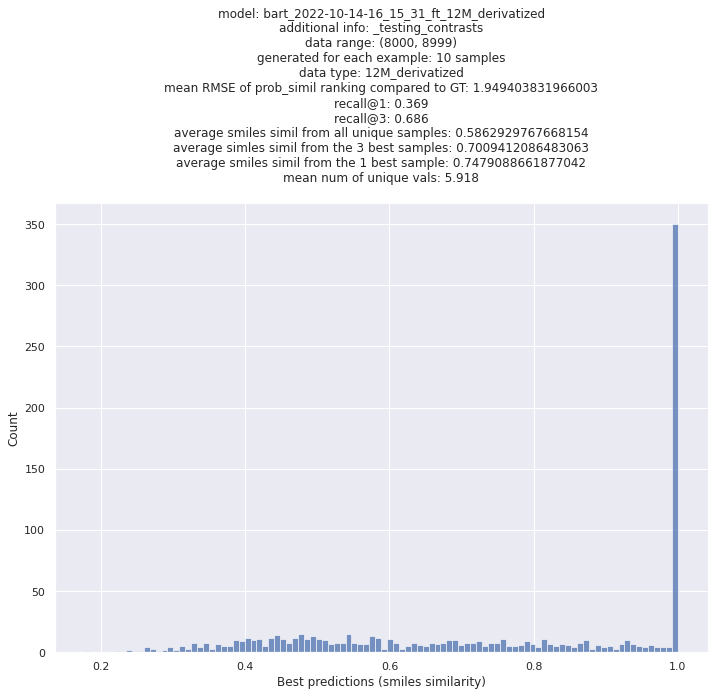

In [16]:
additional_info = "_testing_contrasts"
model_name = ''.join(model_path.split('/')[-3])
RANGE = range(8000, 9000) 

# TOP_K = 6
# PENALTY_ALPHA = 0.6

# for TOP_K in [3, 6, 9]:
#     for PENALTY_ALPHA in [0.4, 0.6, 0.8]:
#         print(f"TOP_K: {TOP_K}, penalty alpha: {PENALTY_ALPHA}")
#         additional_info = f"_testing_contrasts_({TOP_K},{PENALTY_ALPHA})"
evaluate_range_opt2_prob(model, 
                         model_name,
                         tokenizer,
                         test_data,
                         data_type=data_type,
                         num_generated=10,
                         data_range=RANGE,
                         additional_info=additional_info,
                         penalty_alpha=PENALTY_ALPHA,
                         top_k=TOP_K)

# Evaluate datapoints OPTION 2 (dumb)
- generate ?100? SMILES from input spectra
- sort them according to number of SMILES of each kind
- get the recall@1 score and recall@3 scoretoken_probs

In [33]:
# %%time
# append: 10.6
# concat: 10.6
# lists: 10.6
def evaluate_range_opt2_dumb(data, data_range, additional_info="", num_generated=100, top_k=None, top_p=0.8, do_sample=True, num_beams=1, temperature=None, printing=True):
    all_datapoint_ids = []
    all_smiles = []
    for id_ in tqdm(data_range):
        inputs = data[id_]
        if tokenizer_type:
            gt_smiles = tokenizer.decode(list(np.array(inputs["labels"].tolist())*np.array(inputs["decoder_attention_mask"].tolist()))[1:-1])
        else:
            x = np.array(inputs["labels"].tolist())*np.array(inputs["decoder_attention_mask"].tolist())
            gt_smiles = tokenizer.ids_to_smiles(x[x>0][1:-1])
        generated_smiless = []

        # generate
        input_ids = inputs["input_ids"].unsqueeze(0).to(device=device)
        generated_outputs = model.generate(
                               input_ids=input_ids,
                               position_ids=inputs["position_ids"].unsqueeze(0).to(device=device),
                               num_return_sequences = num_generated,
                               top_p=top_p,
                               top_k=top_k,
            #                    min_length=20,
            #                    max_length=200,
                               do_sample=do_sample,
                               num_beams=num_beams,
                               temperature=temperature,
                               return_dict_in_generate=True,
                               output_scores=True)

        # decode the generated SMILESs
        generated_smiless = [tokenizer.decode(generated[1:-1]) for generated in generated_outputs.sequences.tolist()]
        
        # deduplicate (or not)
        unique_smiless = generated_smiless # np.unique(np.array(generated_smiless)) #####################################

        # filter invalid
        valid_smiless = [s for s in unique_smiless if Chem.MolFromSmiles(s)]

        # canonize
        canon_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(smi),True) for smi in valid_smiless]
        
        all_smiles += canon_smiles
        all_datapoint_ids += [id_]*len(canon_smiles)
    
    df_all_data = pd.DataFrame({"datapoint_ID":all_datapoint_ids, "smiles": all_smiles})
    
    success1 = 0
    success3 = 0
    unique_vals = 0
    rmses = []
    for id_ in data_range:
        inputs = data[id_]
        gt_smiles = tokenizer.decode(list(np.array(inputs["labels"].tolist())*np.array(inputs["decoder_attention_mask"].tolist()))[1:-1])
        df_id_subset = df_all_data[df_all_data['datapoint_ID'] == id_].copy()
        
        # compute SMILES simil (just for reference)
        ms = [Chem.MolFromSmiles(smiles) for smiles in df_id_subset["smiles"]]
        gt_fp = Chem.RDKFingerprint(Chem.MolFromSmiles(gt_smiles)) 
        fps = [Chem.RDKFingerprint(x) for x in ms if x]
        smiles_simils = [DataStructs.FingerprintSimilarity(fp, gt_fp) for fp in fps]            
        
        df_id_subset["smiles_simils"] = smiles_simils
        countwise_sorted_SMILES = list(df_id_subset["smiles"].value_counts().keys())
        
        print(countwise_sorted_SMILES)
        # compute values for countwise metric (the higher the better -> substracting from len(...))
        num_unique = len(countwise_sorted_SMILES)
        count_simil = [num_unique - countwise_sorted_SMILES.index(s) for s in df_id_subset["smiles"]]
        
        df_id_subset["countwise_idxs"] = count_simil  
               
         # compare the two simil lists (RMSE)
        rmse, (idxs_count, idxs_GT) = rmse_simils_unique(count_simil, smiles_simils)
        rmses.append(rmse)

        df_id_subset.sort_values(by="smiles_simils", inplace=True)
        gen_SMILES = df_id_subset.smiles.unique()
        best_gen_SMILES = gen_SMILES[0]
        
#                 showing dfs
#         ic(rmse, (idxs_count, idxs_GT))
#         ic(best_gen_SMILES)
#         gt_smiles = tokenizer.decode(list(np.array(inputs["labels"].tolist())*np.array(inputs["decoder_attention_mask"].tolist()))[1:-1])
#         ic(gt_smiles)
#         display(df_id_subset)
#         return
        
        ### STATS        
        # check if different num of unique vals in this simil list pair
        if best_gen_SMILES == countwise_sorted_SMILES[0]:
            success1 += 1 
        if best_gen_SMILES in countwise_sorted_SMILES[:3]:
            success3 += 1
        unique_vals += len(gen_SMILES)
            
    ############## OUTPUT ################
    model_name = ''.join(model_path.split('/')[-3])
    num_of_datapoints = max(data_range)-min(data_range)+1
    output_text = \
      f"model: {model_name}\n" + \
      f"additional info: {additional_info}\n" + \
      f"data range: ({min(data_range)}, {max(data_range)})\n"+ \
      f"generated for each example: {num_generated} samples\n"+\
      f"data type: {data_type}\n" +\
      f"mean RMSE of NEIMS_simil compared to GT: {sum(rmses)/len(rmses)}\n" +\
      f"recall@1: {success1/num_of_datapoints}\n"+\
      f"recall@3: {success3/num_of_datapoints}\n"+\
      f"mean num of unique vals: {unique_vals/num_of_datapoints}\n"
    print( f"###### RESULTS ######\n" + output_text)
    
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    histplot = sns.histplot(rmses, bins=100).set_title(output_text)
    fig = histplot.get_figure()
    
    fig.savefig(f"figures/option2_dumb{additional_info}_{model_name}_{data_type}_({min(data_range)}, {max(data_range)}).png", bbox_inches='tight') 
    return histplot

In [ ]:
evaluate_range(test_data, num_generated=100, data_range=range(14000,15000), additional_info="")

=====================================================================================================
## RCX data evaluation

In [8]:
# importing data
rcx_spectra = load_from_msp("data/rcx_spectra/5_rcx_gc-orbitrap_metabolites_20210817.msp")
rcx_spectra = list(rcx_spectra)
print(f"We have {len(rcx_spectra)} rcx datapoints in total.")

We have 265 rcx datapoints in total.


In [9]:
rcx_spectra[0]

In [40]:
# spectra preprocessing
df_rcx = preprocess_spectra(rcx_spectra, spectra_name="rcx_spectra")

8 no smiles
6 smiles too long
0 spectra corrupted
31 spectra w/ too high mz
4 spectra w/ too many peaks
totally 41 issues
discarded 44/265 spectra 


,input_ids,position_ids,smiles,rcx_spectra
0,"[73, 74, 76, 77, 78, 79, 79, 81, 81, 89, 91, 9...","[4, 3, 3, 3, 2, 3, 7, 5, 1, 1, 1, 3, 4, 2, 4, ...",C/C(O)=N\CCc1cn([Si](C)(C)C)c2ccc(O[Si](C)(C)C...,<matchms.Spectrum.Spectrum object at 0x1482921...
1,"[73, 75, 102, 147, 149, 202, 216, 220, 288, 29...","[5, 1, 2, 1, 1, 1, 1, 2, 3, 9, 6, 5, 2, 7, 4, ...",CC(=O)N(CCc1cn([Si](C)(C)C)c2ccc(O[Si](C)(C)C)...,<matchms.Spectrum.Spectrum object at 0x1482921...
2,"[73, 74, 79, 202, 220, 230, 260, 273, 288, 289...","[5, 1, 1, 3, 4, 2, 1, 1, 5, 2, 9, 6, 5, 1, 3, ...",C/C(O)=N\CCc1cn([Si](C)(C)C)c2ccc(O[Si](C)(C)C...,<matchms.Spectrum.Spectrum object at 0x1482921...
3,"[73, 78, 79, 80, 96, 106, 117, 135, 136, 163, ...","[2, 8, 6, 2, 1, 6, 2, 9, 5, 2, 5, 2, 1, -1, -1...",CNC(=O)c1cccnc1,<matchms.Spectrum.Spectrum object at 0x1482921...
4,"[73, 74, 75, 84, 128, 147, 149, 156, 157, 158,...","[6, 2, 3, 2, 1, 1, 4, 9, 6, 4, 5, 1, -1, -1, -...",C[Si](C)(C)OC(=O)C1CCCCN1[Si](C)(C)C,<matchms.Spectrum.Spectrum object at 0x1483748...
...,...,...,...,...
216,"[70, 73, 74, 75, 76, 77, 79, 91, 100, 101, 102...","[2, 7, 3, 7, 2, 3, 3, 2, 4, 1, 2, 2, 4, 2, 5, ...",CC(=O)NC(CC(=O)O[Si](C)(C)C)C(=O)O[Si](C)(C)C,<matchms.Spectrum.Spectrum object at 0x148291e...
217,"[71, 75, 76, 77, 78, 79, 81, 84, 86, 87, 89, 9...","[2, 4, 4, 5, 3, 5, 2, 1, 3, 3, 2, 2, 2, 3, 3, ...",CC(O[Si](C)(C)C)C(N[Si](C)(C)C)C(=O)O[Si](C)(C)C,<matchms.Spectrum.Spectrum object at 0x148291e...
218,"[73, 74, 75, 76, 77, 79, 84, 85, 89, 91, 93, 9...","[8, 4, 8, 2, 3, 1, 2, 3, 4, 2, 2, 1, 1, 1, 2, ...",CON=C(CCCC(=O)O[Si](C)(C)C)C(=O)O[Si](C)(C)C,<matchms.Spectrum.Spectrum object at 0x148291e...
219,"[73, 74, 75, 76, 78, 84, 85, 89, 91, 91, 93, 9...","[8, 3, 7, 2, 3, 2, 2, 5, 1, 4, 2, 3, 3, 2, 4, ...",CON=C(CCCC(=O)O[Si](C)(C)C)C(=O)O[Si](C)(C)C,<matchms.Spectrum.Spectrum object at 0x148291e...


In [41]:
# test
print(df_rcx.smiles.iloc[1])

CC(=O)N(CCc1cn([Si](C)(C)C)c2ccc(O[Si](C)(C)C)cc12)[Si](C)(C)C


In [42]:
rcx_data = SpectroDataset(df_rcx, original=False, eval_mode=True)

  0%|          | 0/221 [00:00<?, ?it/s]/storage/brno2/home/ahajek/.local-Pytorch-21.SIF/lib/python3.8/site-packages/transformers/generation_utils.py:1202: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 200 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 221/221 [13:53<00:00,  3.77s/it]


###### RESULTS ######
model: bart_2022-10-14-16_15_31_ft_12M_derivatized
additional info: _rcx
data range: (0, 220)
generated for each example: 200 samples
data type: 12M_derivatized
mean RMSE of prob_simil ranking compared to GT: 50.14546198879892
recall@1: 0.013574660633484163
recall@3: 0.06334841628959276
average smiles simil from all unique samples: 0.2803924741838702
average simles simil from the 3 best samples: 0.45391582659537766
average smiles simil from the 1 best sample: 0.4747541365180137
mean num of unique vals: 129.40271493212668



Text(0.5, 1.0, 'model: bart_2022-10-14-16_15_31_ft_12M_derivatized\nadditional info: _rcx\ndata range: (0, 220)\ngenerated for each example: 200 samples\ndata type: 12M_derivatized\nmean RMSE of prob_simil ranking compared to GT: 50.14546198879892\nrecall@1: 0.013574660633484163\nrecall@3: 0.06334841628959276\naverage smiles simil from all unique samples: 0.2803924741838702\naverage simles simil from the 3 best samples: 0.45391582659537766\naverage smiles simil from the 1 best sample: 0.4747541365180137\nmean num of unique vals: 129.40271493212668\n')

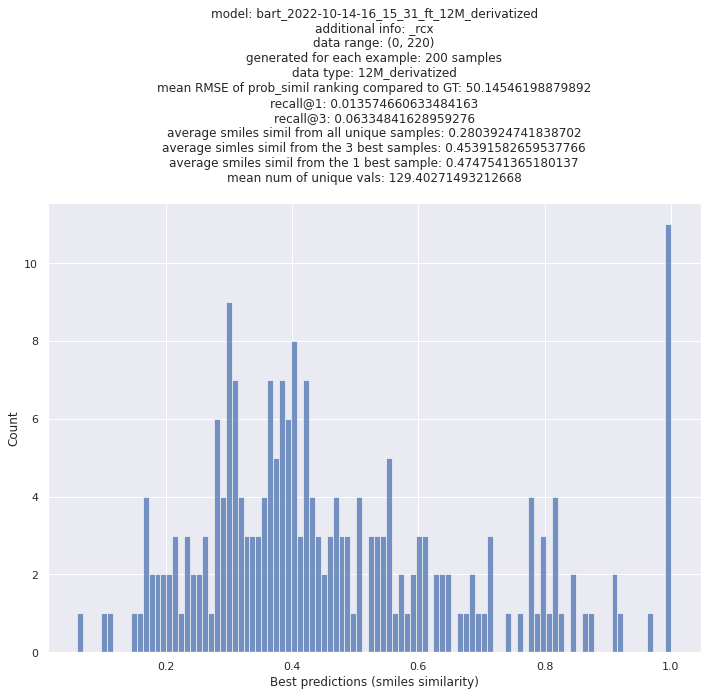

In [43]:
# evaluate whole rcx dataset
additional_info = "_rcx"
evaluate_range_opt2_prob(rcx_data, num_generated=200, data_range=range(0,len(rcx_data.data)), additional_info=additional_info, gt_list=list(df_rcx["smiles"]))

In [ ]:
# visualize predictions for datapoints
id_ = 109
evaluate_datapoint(rcx_data[id_], gt_smiles=df_rcx["smiles"][id_])

## RCX data Silicium statistics

In [126]:
# token number of Si is 1068
num_of_si = 0
for labels in rcx_data.data.smiles:
    if "Si" in labels:
        num_of_si += 1
print(f"{num_of_si}/{len(rcx_data.data)} datapoints include Si atom")

192/200 datapoints include Si atom


## RCX data comparison with NEIMS

In [15]:
def my_position_ids_restorer(log_intensities, log_base=np.log(1.7), log_shift=9):
    """Takes logged intensities and restores them to centers of the bins"""
    intensities = np.around(np.exp((log_intensities - log_shift) * log_base), decimals=4)
    return intensities

def compare_rcx_neims(dataframe = df_rcx, data_range = range(10), additional_info="comp_neims_on_rcx"):
    df_ranged = dataframe.iloc[data_range].copy()
    df_ranged["ID"] = list(data_range)
    print("df_ranged", len(df_ranged))
#     display(df_ranged)
    print("len of unique df_range", len(set(df_ranged["smiles"])))
    
    # generate NEIMS spectra for all rcx SMILESs and do a cosine similarity
    PandasTools.AddMoleculeColumnToFrame(df_ranged, smilesCol='smiles', molCol='rcx_mol')

    # exporting to SDF
    PandasTools.WriteSDF(df_ranged, "./tmp/tmp_for_NEIMS.sdf", properties=["ID", "smiles", "rcx_mol"], molColName="rcx_mol")
        
    ################# NEIMS bash commands #####################    
    print("RUN IN TERMINAL: " + "bash ~/Spektro/MassGenie/geneval_extended_support_script.sh")
    ans=""
    while ans!="y":
        ans = input("Has the script finished? [y/n]: ")
    print("OK..\n")
    ###########################################################
    # load sdf
    df_enriched = PandasTools.LoadSDF("./tmp/tmp_for_NEIMS_enriched.sdf", idName="ID", molColName='mol')
    df_enriched = oneD_spectra_to_mz_int(df_enriched)
    print("len df_enriched", len(df_enriched))
    df_merged = pd.merge(df_enriched, df_ranged, on="smiles", how="inner")
    print("len df_merged", len(df_merged))
    ####### DROPPPPP?????
    df_merged.drop(columns=["mol", "ID_y", "input_ids", "position_ids"], inplace=True)

#     display(df_merged)
    
    # compute NEIMS simil
    rcx_intensities = np.array([np.array(s.peaks.intensities)/np.array(s.peaks.intensities).max() for s in df_merged.rcx_spectra]) # already scaled by max value
    rcx_mzs = np.array([np.array(s.peaks.mz).round() for s in df_merged.rcx_spectra])
    rcx_specs = [Spectrum(mz=rcx_mzs[i], 
                           intensities=rcx_intensities[i])
                  for i in range(len(rcx_intensities))]
    gen_specs = [Spectrum(mz=np.array(row[1]["mz"], dtype=float), intensities=np.array(row[1]["intensity"])) for row in df_merged.iterrows()]
    cosine_greedy = CosineGreedy(tolerance=0.0) # tolerance je stejne naprd
    cossim_out = cosine_greedy.matrix(references=rcx_specs, queries=gen_specs)
    neims_simils = [x[0] for x in cossim_out[0]]
    matched_peaks = [x[1] for x in cossim_out[0]]

    df_merged["NEIMS_matched_peaks"] = matched_peaks
    df_merged["num_rcx_peaks"] = [len(s.peaks) for s in df_merged["rcx_spectra"]]
    df_merged["rcx_mzs"] = pd.Series(rcx_mzs)
    df_merged["rcx_intensities"] = rcx_intensities
    df_merged["spectra_simil"] = neims_simils
#     df_merged["spectra"] = [rcx_specs[i].plot_against(gen_specs[i], figsize=(8, 6)) for i in range(len(gen_specs))]
    df_merged.rename(columns = {"mz": "NEIMS_mz", "intensity": "NEIMS_intensity"}, inplace=True)
#     df_merged.drop(columns = ["input_ids"])
    
    
    ############################################
    model_name = ''.join(model_path.split('/')[-3])
    num_of_datapoints = max(data_range)-min(data_range)+1
    output_text = \
      f"additional info: {additional_info}\n" + \
      f"data range: ({min(data_range)}, {max(data_range)})\n"+ \
      f"data type: rcx_data\n" +\
      f"mean spectra cos simil: {df_merged['spectra_simil'].mean()}\n"
    print(f"###### RESULTS ######\n" + output_text)
    
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    histplot = sns.histplot(df_merged.spectra_simil, bins=100).set_title(output_text)
    fig = histplot.get_figure()
    plt.xlabel("spectrum cosine similarity")
    fig.savefig(f"figures/{additional_info}_{model_name}_rcx_data_({min(data_range)}, {max(data_range)}).png", bbox_inches='tight') 
    return histplot
                           
    return df_merged

df_ranged 199
len of unique df_range 199
RUN IN TERMINAL: bash ~/Spektro/MassGenie/geneval_extended_support_script.sh


Has the script finished? [y/n]:  y


OK..

len df_enriched 199
len df_merged 199


<ipython-input-181-4b01e75630df>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rcx_intensities = np.array([np.array(s.peaks.intensities)/np.array(s.peaks.intensities).max() for s in df_merged.rcx_spectra]) # already scaled by max value
<ipython-input-181-4b01e75630df>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rcx_mzs = np.array([np.array(s.peaks.mz).round() for s in df_merged.rcx_spectra])


###### RESULTS ######
additional info: comp_neims_on_rcx
data range: (0, 198)
data type: rcx_data
mean spectra cos simil: 0.0791226412999965



Text(0.5, 1.0, 'additional info: comp_neims_on_rcx\ndata range: (0, 198)\ndata type: rcx_data\nmean spectra cos simil: 0.0791226412999965\n')

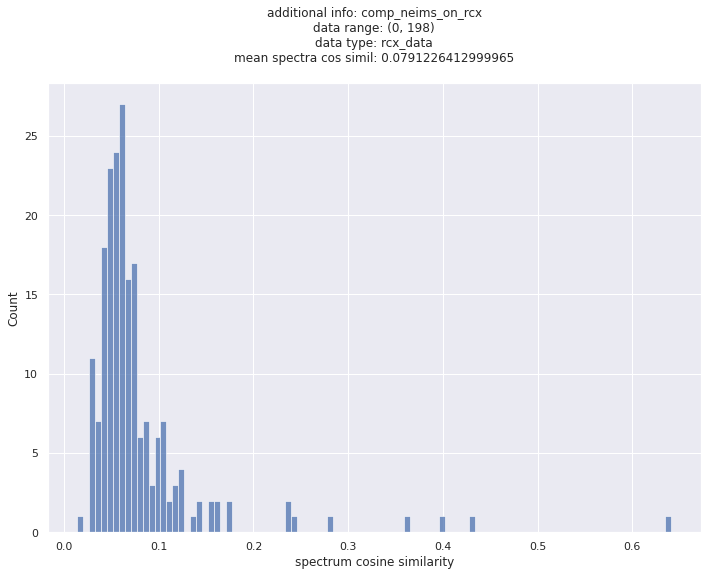

In [182]:
compare_rcx_neims(data_range=range(len(df_rcx)))

## Compare NIST spectra to NEIMS generation
- deriv vs. nonderiv

In [183]:
def prepro

SyntaxError: invalid syntax (<ipython-input-183-5e251c77a44e>, line 1)

In [16]:
df_rcx

,input_ids,position_ids,smiles,rcx_spectra
0,"[73, 74, 76, 77, 78, 79, 79, 81, 81, 89, 91, 9...","[4, 3, 3, 3, 2, 3, 7, 5, 1, 1, 1, 3, 4, 2, 4, ...",C/C(O)=N\CCc1cn([Si](C)(C)C)c2ccc(O[Si](C)(C)C...,<matchms.Spectrum.Spectrum object at 0x14bfc5a...
1,"[73, 75, 102, 147, 149, 202, 216, 220, 288, 29...","[5, 1, 2, 1, 1, 1, 1, 2, 3, 9, 6, 5, 2, 7, 4, ...",CC(=O)N(CCc1cn([Si](C)(C)C)c2ccc(O[Si](C)(C)C)...,<matchms.Spectrum.Spectrum object at 0x14bfc5a...
3,"[73, 78, 79, 80, 96, 106, 117, 135, 136, 163, ...","[2, 8, 6, 2, 1, 6, 2, 9, 5, 2, 5, 2, 1, -1, -1...",CNC(=O)c1cccnc1,<matchms.Spectrum.Spectrum object at 0x14bfc5a...
4,"[73, 74, 75, 84, 128, 147, 149, 156, 157, 158,...","[6, 2, 3, 2, 1, 1, 4, 9, 6, 4, 5, 1, -1, -1, -...",C[Si](C)(C)OC(=O)C1CCCCN1[Si](C)(C)C,<matchms.Spectrum.Spectrum object at 0x14bfc5a...
5,"[112, 114, 131, 142, 143, 143, 144, 156, 157, ...","[1, 4, 3, 8, 3, 4, 2, 5, 1, 4, 2, 2, 9, 5, 3, ...",C[Si](C)(C)OC(=O)C1CCCCN1,<matchms.Spectrum.Spectrum object at 0x14bfc5a...
...,...,...,...,...
214,"[75, 79, 86, 93, 100, 104, 105, 106, 107, 116,...","[3, 4, 2, 2, 3, 1, 6, 4, 3, 1, 2, 9, 2, 3, 1, ...",COc1ccccc1C(=O)O[Si](C)(C)C,<matchms.Spectrum.Spectrum object at 0x14bfc50...
215,"[73, 74, 75, 77, 78, 80, 81, 81, 91, 95, 106, ...","[7, 3, 5, 1, 4, 3, 5, 2, 3, 2, 2, 2, 2, 2, 1, ...",Cc1cn(C2OC(CO[Si](C)(C)C)C(O[Si](C)(C)C)C2O[Si...,<matchms.Spectrum.Spectrum object at 0x14bfc50...
216,"[70, 73, 74, 75, 76, 77, 79, 91, 100, 101, 102...","[2, 7, 3, 7, 2, 3, 3, 2, 4, 1, 2, 2, 4, 2, 5, ...",CC(=O)NC(CC(=O)O[Si](C)(C)C)C(=O)O[Si](C)(C)C,<matchms.Spectrum.Spectrum object at 0x14bfc50...
218,"[73, 74, 75, 76, 77, 79, 84, 85, 89, 91, 93, 9...","[8, 4, 8, 2, 3, 1, 2, 3, 4, 2, 2, 1, 1, 1, 2, ...",CON=C(CCCC(=O)O[Si](C)(C)C)C(=O)O[Si](C)(C)C,<matchms.Spectrum.Spectrum object at 0x14bfc50...


In [36]:
type(tokenizer)

tokenizers.Tokenizer